# Figure 3 
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Import dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
import matplotlib.collections as collections
from scipy import stats

Data locations

In [2]:
loc_lens = "../Data/Probabilities/LENS/"
loc_cmip = "../Data/Probabilities/CMIP5/"
loc_obs = "../Data/Probabilities/"

Set boxplot color

In [3]:
def set_boxplot_col(b,n,c,lw,median):
    
    # This function sets the colors of a given boxplot b
    # It auto-sets the colors of the boxes, whiskers, caps, and fliers to c
    # and it sets the colors of the medians if median=True
    # n is the number of instances of the boxplot and lw is the desired
    # linewidth
    
    for m in range(0,n*2,1):
        if m < n:
            b["boxes"][m].set(color=c,linewidth=lw)
            b["whiskers"][m].set(color=c,linewidth=lw)
            b["caps"][m].set(color=c,linewidth=lw)
            #b["fliers"][m].set(markerfacecolor=c,markeredgecolor=c)
            if median==True:
                b["medians"][m].set(color=c,linewidth=lw)
        else:
            b["whiskers"][m].set(color=c,linewidth=lw)
            b["caps"][m].set(color=c,linewidth=lw)

#### Analysis

Read in obs probabilities

In [4]:
y1_met = 1981
y2_met = 2010
y1_aq = 2008
y2_aq = 2020

# haze given bins, etc
joint_probs_file = xr.open_dataset(loc_obs+"SOM_PC1_AQ_JOINT_PROBS_"+str(y1_aq)+"-"+str(y2_aq)+".nc")
joint_probs_obs = xr.DataArray(joint_probs_file.data_vars["PROBS"])
joint_probs_median = joint_probs_obs.median(dim="boot")
#haze_bins_flat = joint_probs_median.values.flatten()

# prob pc1/node
joint_occurrence_file = xr.open_dataset(loc_obs+"SOM_PC1_JOINT_OCCURRENCE_"+str(y1_met)+"-"+str(y2_met)+".nc")
joint_occurrence = xr.DataArray(joint_occurrence_file.data_vars["PROBS"])
joint_occurrence_median = joint_occurrence.median(dim="boot")

Calculate obs haze probability

In [5]:
p_haze = (joint_probs_obs * joint_occurrence).sum(dim=["node","bin"])

Read in modeled probabilities

In [6]:
joint_occ_file_lens = xr.open_dataset(loc_lens+"LENS_SOM_PC1_JOINT_OCCURRENCE_1981CLM_TEMPTARGET.nc")
joint_occ_file_cmip = xr.open_dataset(loc_cmip+"CMIP5_SOM_PC1_JOINT_OCCURRENCE_1981CLM_TEMPTARGET.nc")

joint_occ_lens = xr.DataArray(joint_occ_file_lens.data_vars["FRACTION"])
joint_occ_cmip = xr.DataArray(joint_occ_file_cmip.data_vars["FRACTION"])

p_haze_lens_file = xr.open_dataset(loc_lens+"LENS_HAZE_FRACTION_1981CLM_TEMPTARGET.nc")
p_haze_cmip_file = xr.open_dataset(loc_cmip+"CMIP5_HAZE_FRACTION_1981CLM_TEMPTARGET.nc")

p_haze_lens = xr.DataArray(p_haze_lens_file.data_vars["FRACTION"])
p_haze_cmip = xr.DataArray(p_haze_cmip_file.data_vars["FRACTION"])

joint_occ_file_lens_change = xr.open_dataset(loc_lens+"LENS_SOM_PC1_JOINT_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")
joint_occ_file_cmip_change = xr.open_dataset(loc_cmip+"CMIP5_SOM_PC1_JOINT_OCCURRENCE_CHANGE_1981CLM_TEMPTARGET.nc")

joint_occ_lens_change = xr.DataArray(joint_occ_file_lens_change.data_vars["FRACTION"])
joint_occ_cmip_change = xr.DataArray(joint_occ_file_cmip_change.data_vars["FRACTION"])

calculate SN

In [7]:
lens_change_em = joint_occ_lens_change.mean(dim="run")
cmip_change_em = joint_occ_cmip_change.mean(dim="model")

lens_change_sd = joint_occ_lens_change.std(dim="run")
cmip_change_sd = joint_occ_cmip_change.std(dim="model")

In [8]:
lens_sn = np.abs(lens_change_em)/np.abs(lens_change_sd)
cmip_sn = np.abs(cmip_change_em)/np.abs(cmip_change_sd)

lens_sn_robust = (lens_sn >= 1).astype(int)
cmip_sn_robust = (cmip_sn >= 1).astype(int)

#### Plotting

In [9]:
def triatpos(pos=(0,0), rot=0):
    r = np.array([[-1,-1],[1,-1],[1,1],[-1,-1]])*.5
    rm = [[np.cos(np.deg2rad(rot)), -np.sin(np.deg2rad(rot))],
           [np.sin(np.deg2rad(rot)),np.cos(np.deg2rad(rot)) ] ]
    r = np.dot(rm, r.T).T
    r[:,0] += pos[0]
    r[:,1] += pos[1]
    return r

In [10]:
ndays_yr = 31 + 31 + 28
nyears = 10
ndays = ndays_yr*nyears

In [11]:
temp_targets = p_haze_lens.coords["temp_target"].values

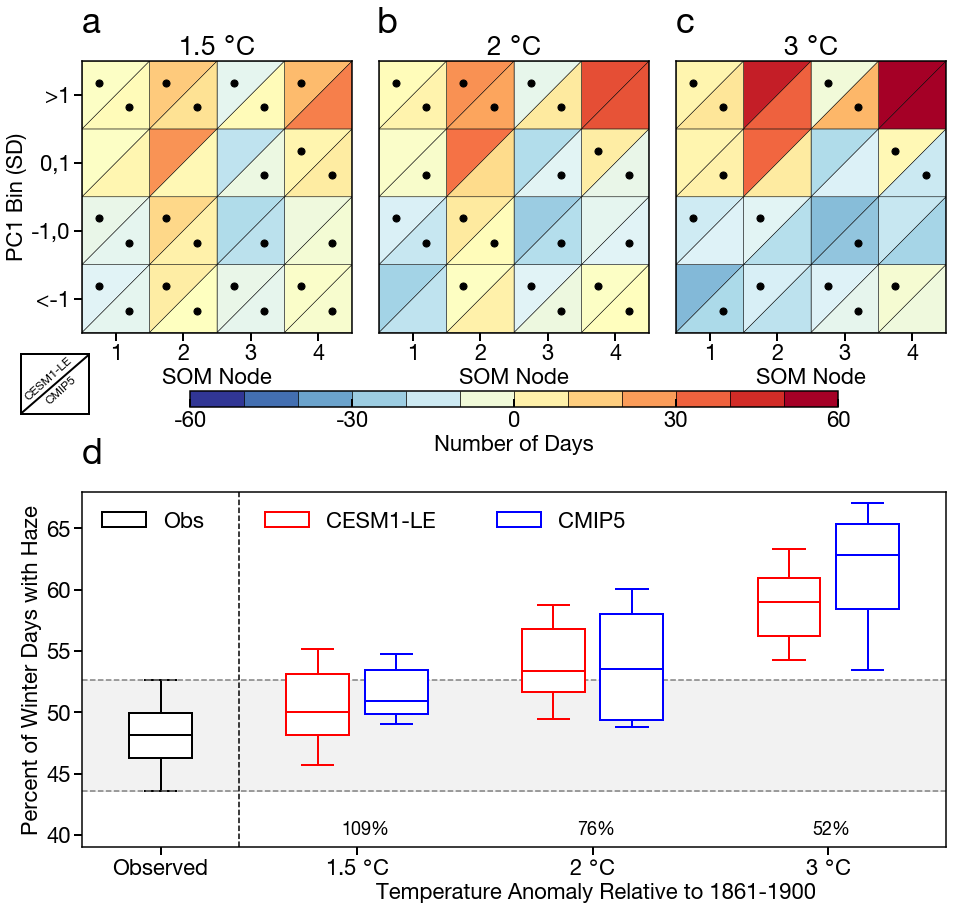

In [12]:
fig = plt.figure(figsize=(15,13))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 22.0
rcParams["axes.linewidth"] = 1.5
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 2


### Joint prob changes

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.1,right=0.9,top=0.9,bottom=0.61,wspace=0.1,hspace=0.2)

#periods_change = [2030,2060,2090]

for ii in np.arange(0,3,1):
    
    ax = plt.subplot(gs1[0,ii])
    temp = temp_targets[ii]
    #y1_period = str(periods_change[ii])
    #y2_period = str(periods_change[ii] + 6)
    
    #lens = lens_change_em.loc[periods_change[ii],:,:]*ndays
    #cmip = cmip_change_em.loc[periods_change[ii],:,:]*ndays
    lens = lens_change_em.loc[temp,:,:]*ndays
    cmip = cmip_change_em.loc[temp,:,:]*ndays
    
    
    colmap = "RdYlBu_r"
    vmin = -60
    vmax = 60
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm,cmap=plt.cm.get_cmap(colmap,12))

    def triamatrix(a, ax, rot=0, **kwargs):
        segs = []
        for i in range(a.shape[0]):
            for j in range(a.shape[1]):
                segs.append(triatpos((j,i), rot=rot) )
        col = collections.PolyCollection(segs, cmap=colmap,norm=norm,edgecolors="black",linewidths=0.5)
        col.set_array(a.flatten())
        ax.add_collection(col)
        return col

    #im1 = triamatrix(joint_occ_lens_error[::-1,::-1].values, ax, rot=180)
    #im2 = triamatrix(joint_occ_cmip_error[::-1,::-1].values, ax, rot=0)
    im1 = triamatrix(np.transpose(lens.values), ax, rot=180)
    im2 = triamatrix(np.transpose(cmip.values), ax, rot=0)

    # S/N dots
    lens_robust = np.transpose(lens_sn_robust.loc[temp,:,:].values)
    cmip_robust = np.transpose(cmip_sn_robust.loc[temp,:,:].values)
    for jj in np.arange(0,4,1):
        for kk in np.arange(0,4,1):
            if lens_robust[jj,kk] == 0:
                plt.scatter(jj-0.25,kk+0.18,color="black",s=50)
            if cmip_robust[jj,kk] == 0:
                plt.scatter(jj+0.2,kk-0.18,color="black",s=50)
    
    plt.xticks(ticks=[0,1,2,3],labels=["1","2","3","4"])
    if ii == 0:
        plt.yticks(ticks=[0,1,2,3],labels=["<-1","-1,0","0,1",">1"])
        plt.ylabel("PC1 Bin (SD)")
    else:
        plt.yticks([])
        
    plt.xlim([-0.5,3.5])
    plt.ylim([-0.5,3.5])
    plt.xlabel("SOM Node")
    if ii == 0:
        plt.title(str(temp)+" $\degree$C")
    else:
        plt.title(str(int(temp))+" $\degree$C")
    

    #plt.title("Difference Between"+"\n"+"Model/Obs Fractions")

# colorbar
cbar_ax = fig.add_axes([0.2, 0.53, 0.6, 0.018])
cb = fig.colorbar(cbar,cax=cbar_ax,orientation='horizontal',drawedges=True,extend="neither") #,shrink=0.5,pad=0.1)
cbar_ax.tick_params(direction="in")
cb.set_ticks([-60,-30,0,30,60])
cb.set_ticklabels(["-60","-30","0","30","60"])
cb.set_label("Number of Days")




### Haze projections


gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.1,right=0.9,top=0.44,bottom=0.06,wspace=0.29,hspace=0.2)

ax = plt.subplot(gs2[0,0])

positions_lens = [1,4,7]
positions_cmip = [2,5,8]
#positions_lens = [1,4,7,10,13,16,19,22]
#positions_cmip = [2,5,8,11,14,17,20,23]

b0 = plt.boxplot(p_haze.values,positions=[-1],widths=0.8,patch_artist=True,sym="",whis=[5,95])
b1 = plt.boxplot(p_haze_lens.values,positions=positions_lens,widths=0.8,patch_artist=True,sym="",whis=[5,95])
b2 = plt.boxplot(p_haze_cmip.values,positions=positions_cmip,widths=0.8,patch_artist=True,sym="",whis=[5,95])

set_boxplot_col(b0,1,"black",2,True)
set_boxplot_col(b1,3,"red",2,True)
set_boxplot_col(b2,3,"blue",2,True)
for patch in b1["boxes"]:
    patch.set(facecolor="white")
for patch in b2["boxes"]:
    patch.set(facecolor="white")
for patch in b0["boxes"]:
    patch.set(facecolor="white")
    
    
for ii in np.arange(0,p_haze_lens.values.shape[1],1):
    #lens_max = np.amax(p_haze_lens[:,ii].values)
    #cmip_max = np.amax(p_haze_cmip[:,ii].values)
    
    lens_period = p_haze_lens[:,ii].values
    cmip_period = p_haze_cmip[:,ii].values
    
    max_both = np.amax([np.percentile(lens_period,95),np.percentile(cmip_period,95)])
    
    range_lens = np.percentile(lens_period,95) - np.percentile(lens_period,5)
    range_cmip = np.percentile(cmip_period,95) - np.percentile(cmip_period,5)
    span = ((range_lens/range_cmip)*100).astype(int)
    
    plt.text(positions_lens[ii]+0.3,0.4,str(span)+"%",fontsize=18,color="black")
    #plt.text(positions_lens[ii]-0.45,0.3,str(span)+"% CMIP5"+"\n"+"spanned by"+"\n"+"CESM1-LE",fontsize=12)
    
    
lower_bound = np.percentile(p_haze.values,5)
upper_bound = np.percentile(p_haze.values,95)
plt.axhline(y=lower_bound,linewidth=1.5,linestyle="--",color="gray")
plt.axhline(y=upper_bound,linewidth=1.5,linestyle="--",color="gray")
plt.axvline(x=0,linewidth=1.5,linestyle="--",color="black")
ax.fill_between([-2,9],lower_bound,upper_bound,color="gray",alpha=0.1)

plt.legend([b0["boxes"][0],b1["boxes"][0],b2["boxes"][0]],["Obs","CESM1-LE","CMIP5"],
           loc="upper left",frameon=False,ncol=3,columnspacing=2.75)

plt.xlim([-2,9])
plt.ylim([0.39,0.68])

lbs = ["Observed","1.5 $\degree$C","2 $\degree$C","3 $\degree$C"]
#lbls = ["2010-16","2020-26","2030-36","2040-46","2050-56","2060-66","2070-76","2080-86","2090-96"]
#lbls = ["2010-16","2030-36","2050-56","2070-76","2090-96"]
#plt.xticks(ticks=[-1,1.5,4.5,7.5,10.5,13.5,16.5,19.5,22.5],labels=lbls,rotation=0,ha="center")
plt.xticks(ticks=[-1,1.5,4.5,7.5],labels=lbs,rotation=0,ha="center")
#plt.xticks(ticks=[-1,4.5,10.5,16.5,22.5],labels=lbls,rotation=0,ha="center")
plt.yticks(ticks=[0.4,0.45,0.5,0.55,0.6,0.65],labels=["40","45","50","55","60","65"])

plt.ylabel("Percent of Winter Days with Haze")
plt.xlabel("Temperature Anomaly Relative to 1861-1900",x=0.595,y=1)

#ax.xaxis.set_tick_params(length=5,width=1.5)
#ax.yaxis.set_tick_params(length=5,width=1.5)

## Box legend

box_ax = fig.add_axes([0.04,0.52,0.07,0.07])
plt.axhline(y=1,xmin=0.05,xmax=0.95,linewidth=2,linestyle="-",color="black")
plt.axhline(y=0,xmin=0.05,xmax=0.95,linewidth=2,linestyle="-",color="black")
plt.axvline(x=0,ymin=0.05,ymax=0.95,linewidth=2,linestyle="-",color="black")
plt.axvline(x=1,ymin=0.05,ymax=0.95,linewidth=2,linestyle="-",color="black")

plt.plot([0.02,0.98],[0.02,0.98],linewidth=2,color="black")

plt.text(0.04,0.22,"CESM1-LE",rotation=42,fontsize=12)
plt.text(0.34,0.16,"CMIP5",rotation=42,fontsize=12)

plt.axis('off')


## figtext

plt.figtext(0.1,0.93,"a",fontsize=35)
plt.figtext(0.373,0.93,"b",fontsize=35)
plt.figtext(0.65,0.93,"c",fontsize=35)
plt.figtext(0.1,0.47,"d",fontsize=35)


#plt.savefig("../Figures/Figure3.pdf")
plt.show()